In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Input of dataset
directory = 'face_dataset/'
whole_data = []
data_train = []
data_test = []
Original_dim = (0,0)
labels = {}
ind = 0
cut = 60
for folder in os.listdir(directory):
    tmp_data = []
    for file in os.listdir(directory+folder+'/'):
        img = cv2.imread(directory+folder+'/'+file)
#         img = cv2.resize(img, (100,100))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        Original_dim = img.shape
        img = img.flatten()
        tmp_data.append(img)
    sz = len(tmp_data)
    sz1 = cut / 100 * sz
    for i in range(sz):
        if i < sz1:
            label = folder
            if label in labels:
                labels[label].append(ind)
            else:
                labels[label] = []
                labels[label].append(ind)
            ind +=1
            data_train.append(tmp_data[i])
        else:
            data_test.append([tmp_data[i],folder])
data_train = np.asarray(data_train)
data_test = np.asarray(data_test)
print(data_train.shape)
print(data_test.shape)
print(Original_dim)

(240, 10304)
(160, 2)
(112, 92)


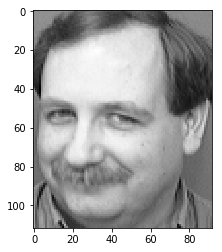

In [3]:
plt.imshow(data_train[19].reshape(Original_dim), cmap = 'gray')

In [4]:
# Normalization and Training
mean = np.mean(data_train, axis = 0)
stddev = np.std(data_train, axis = 0)
average_data = (data_train - mean)
covarience = 1 /  len(average_data) * average_data@average_data.T
eigen_vectors,v,d = np.linalg.svd(covarience)
K = 30
Keigen_vectors = eigen_vectors[:,:K]
eigen_faces = Keigen_vectors.T@average_data
weights = average_data@eigen_faces.T
print(eigen_faces.shape)

(30, 10304)


In [5]:
#LDA
scatter_within = np.zeros((K,K))
scatter_between = np.zeros((K,K))
weights_mean = np.mean(weights, axis = 0).reshape((K,1))
for name, indexes in labels.items():
    mat_class = np.copy(weights[indexes])
    mean_class = np.mean(mat_class, axis = 0).reshape(K,1)
    scatter_within += ((mat_class - mean_class.T).T@(mat_class - mean_class.T))
    scatter_between += ((mean_class - weights_mean)@(mean_class - weights_mean).T)
J = np.linalg.inv(scatter_within)@scatter_between
LDAeigan_vectors , v, d = np.linalg.svd(J)
K2 = 20
LDAKeigan_vectors = LDAeigan_vectors[:,:K2]
Fisher_faces = weights@LDAKeigan_vectors
print(Fisher_faces.shape)

(240, 20)


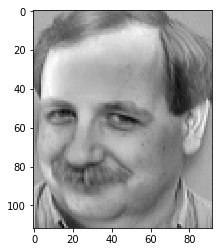

In [6]:
plt.imshow(average_data[19].reshape((Original_dim)), cmap = 'gray')

/home/luv/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Accuracy 93.125


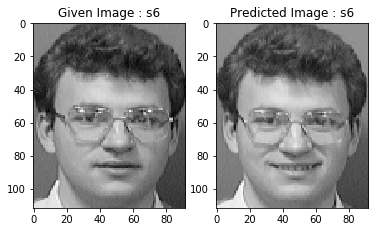

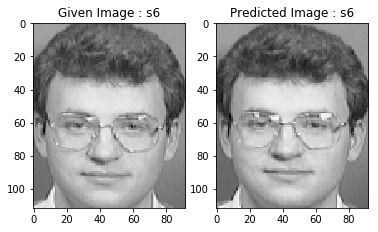

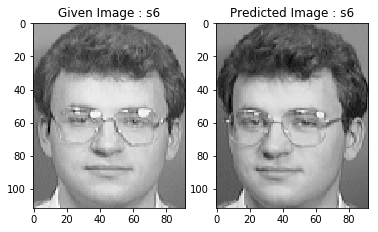

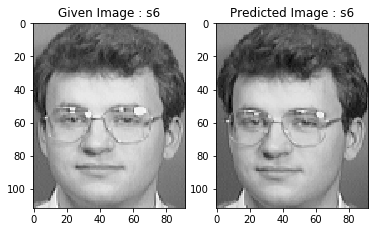

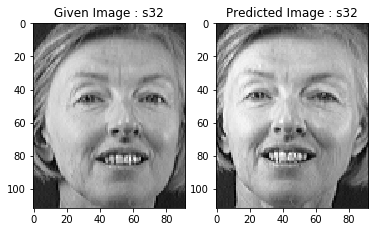

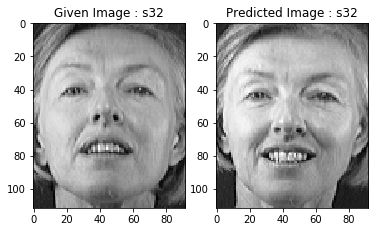

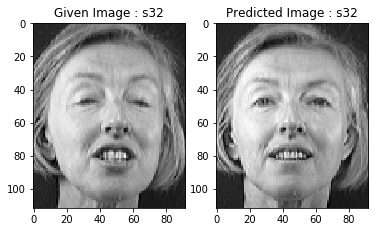

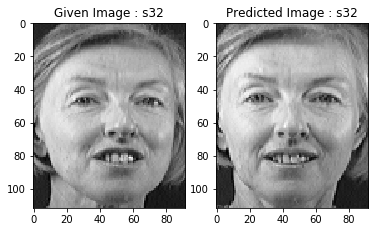

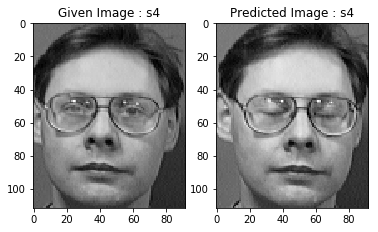

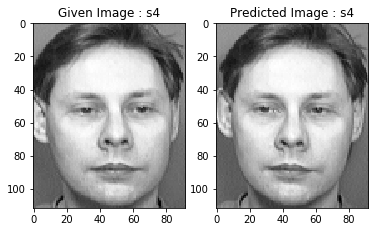

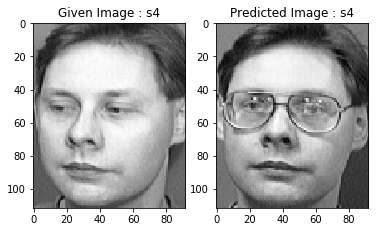

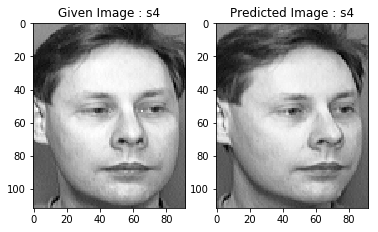

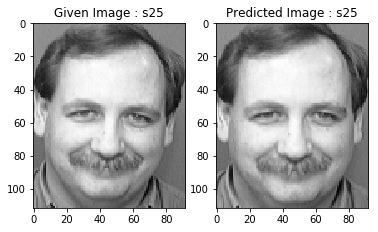

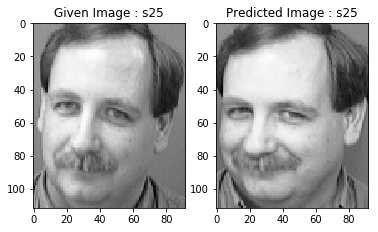

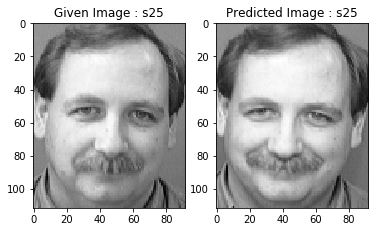

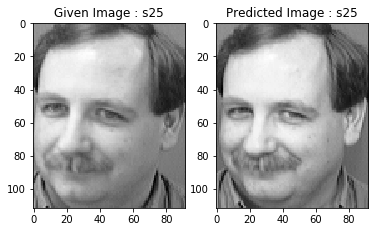

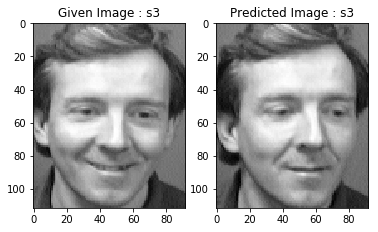

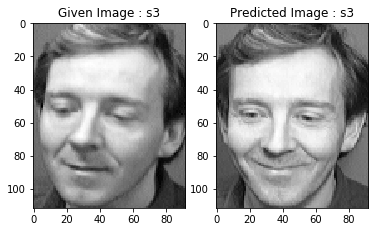

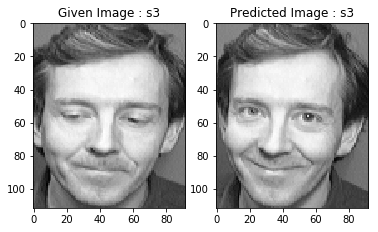

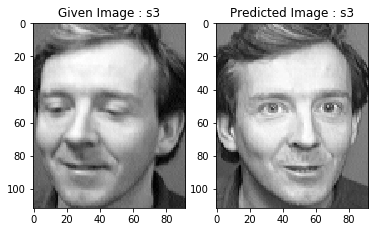

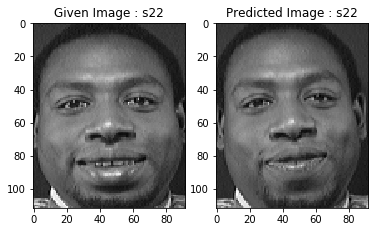

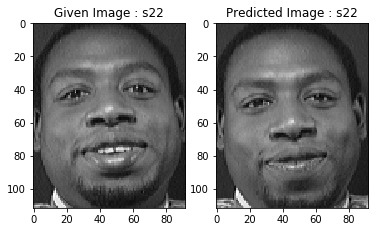

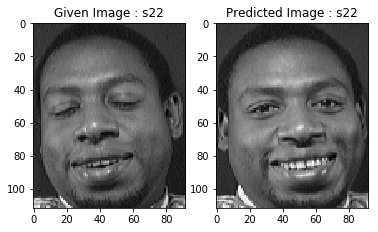

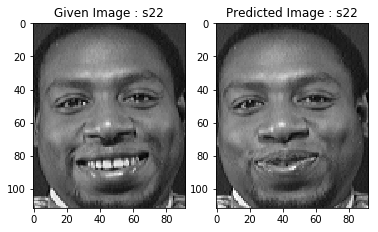

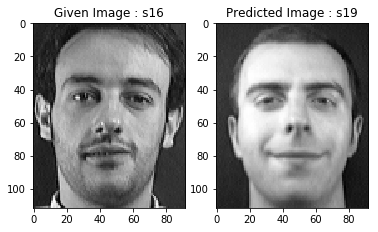

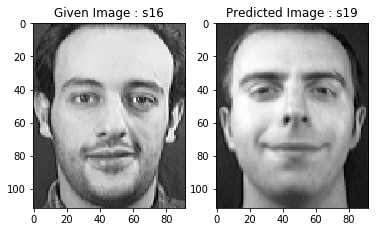

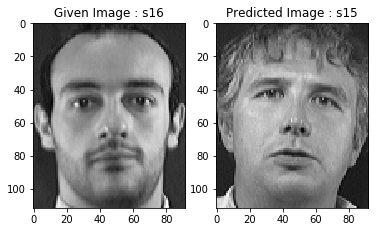

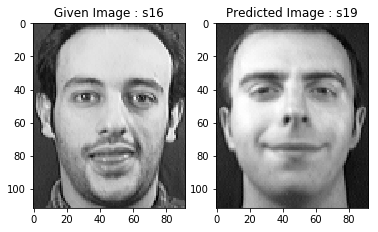

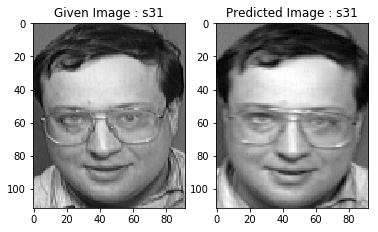

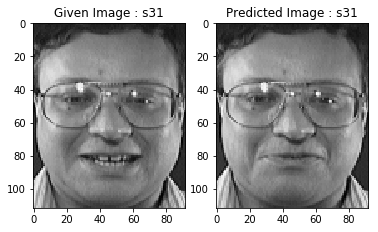

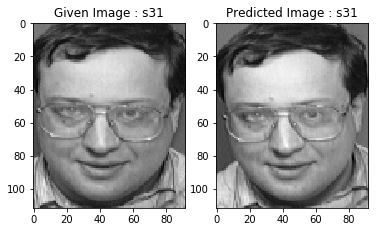

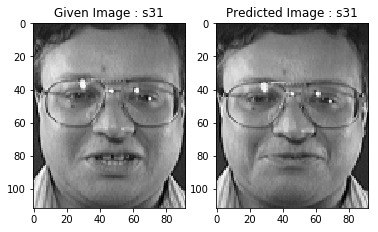

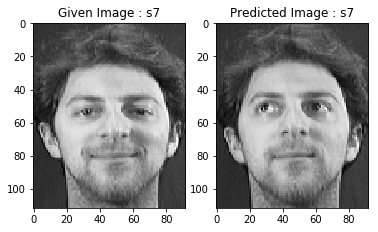

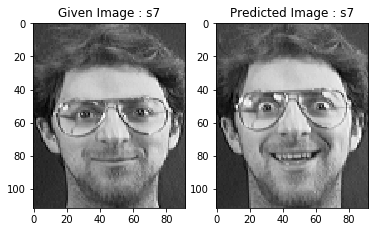

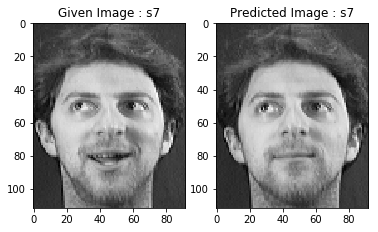

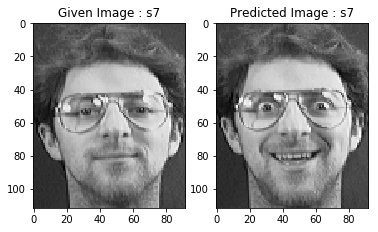

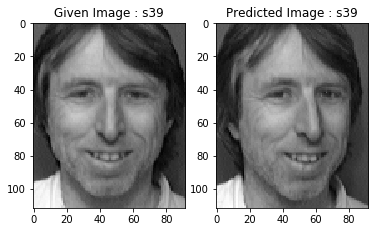

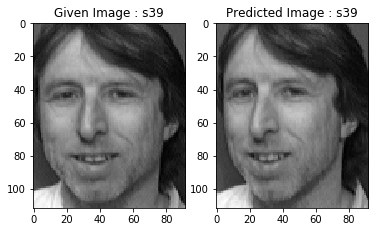

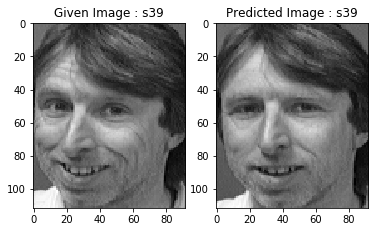

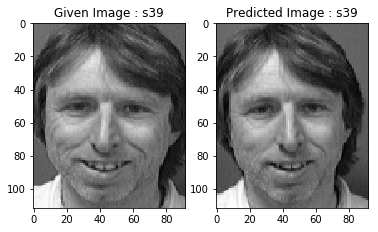

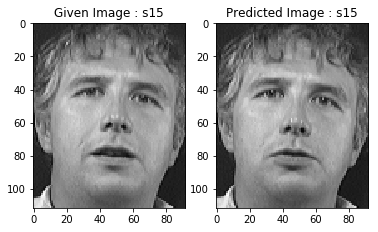

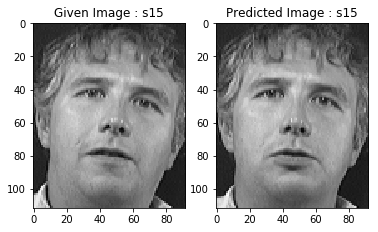

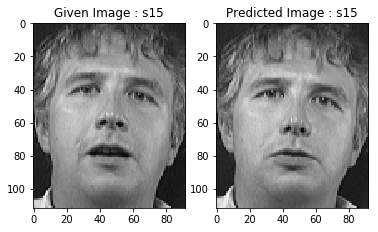

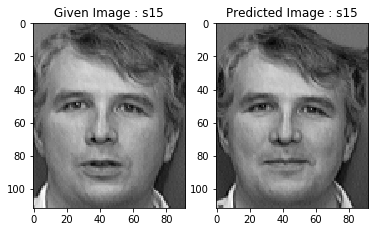

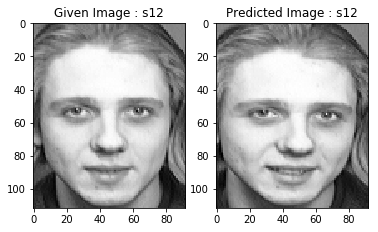

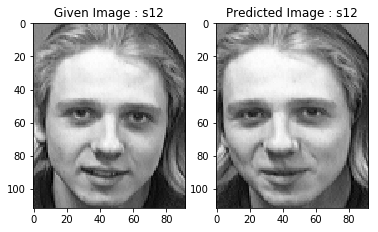

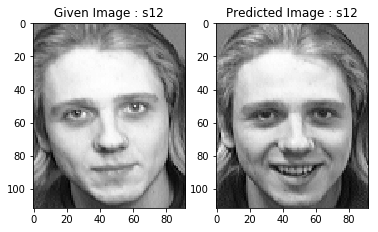

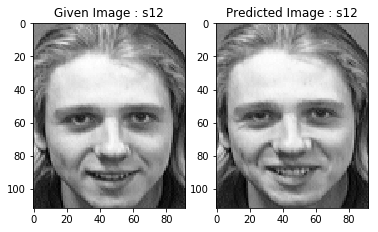

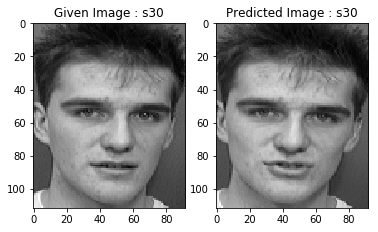

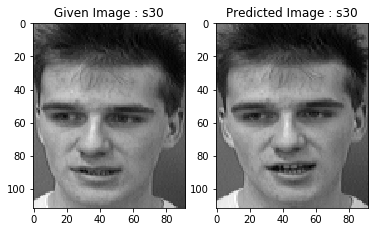

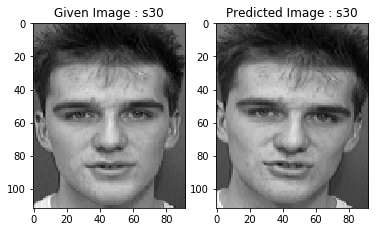

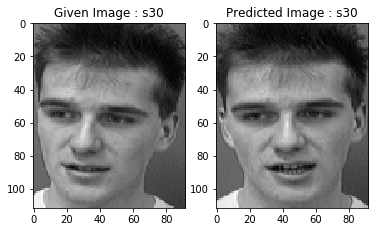

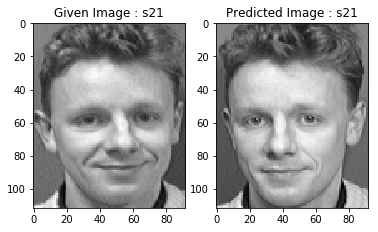

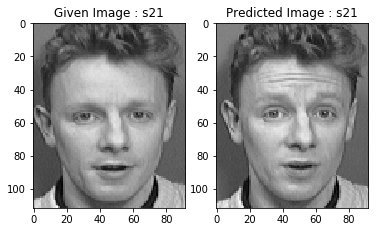

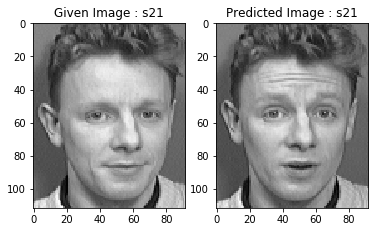

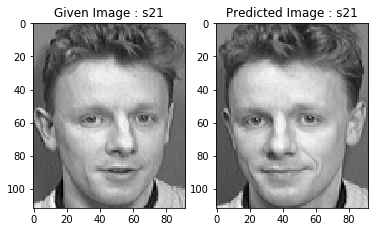

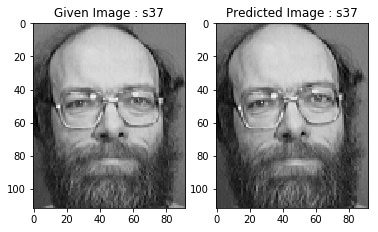

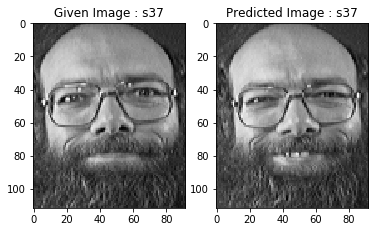

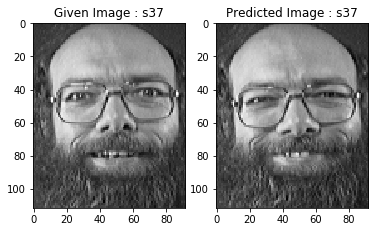

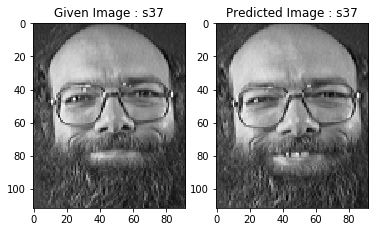

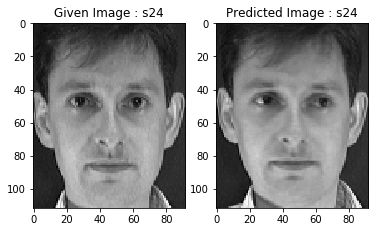

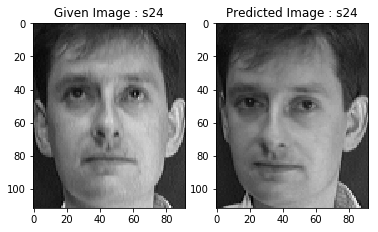

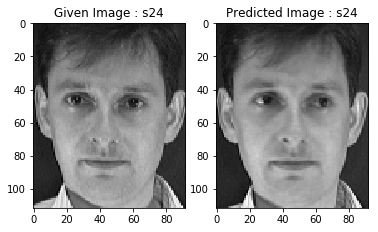

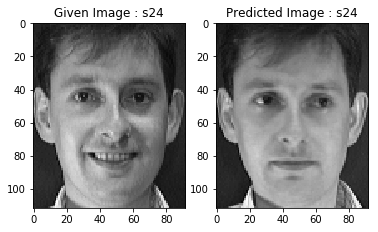

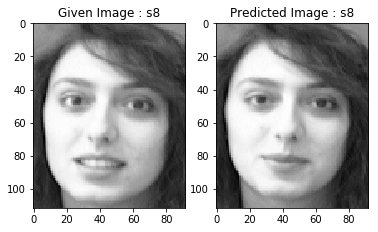

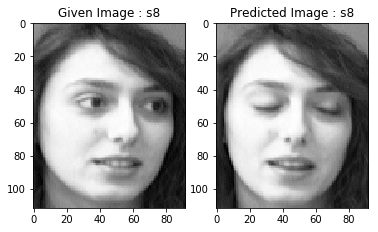

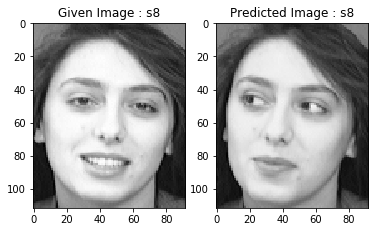

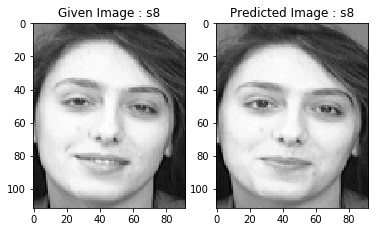

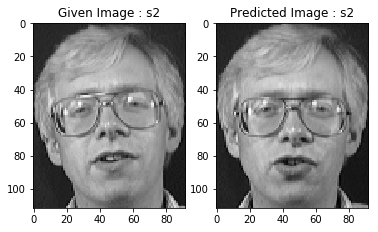

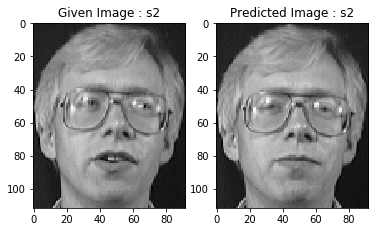

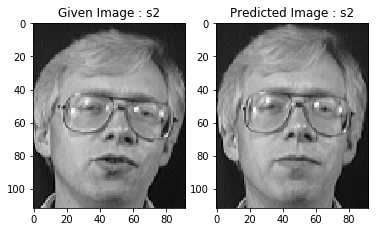

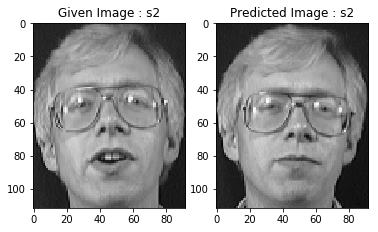

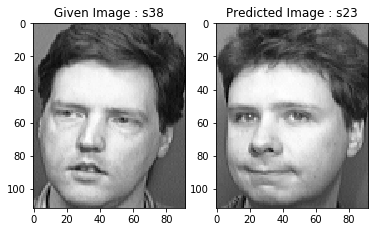

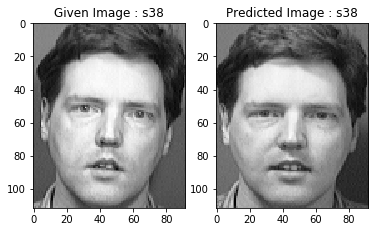

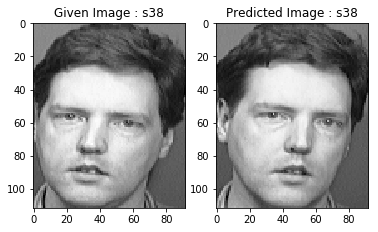

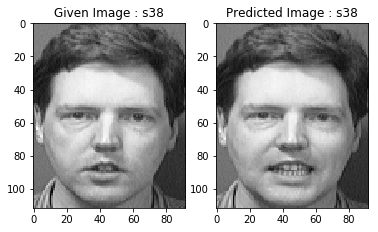

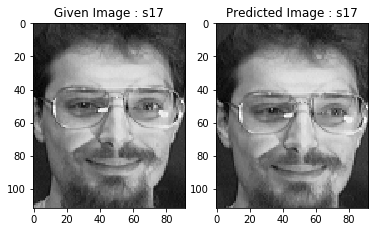

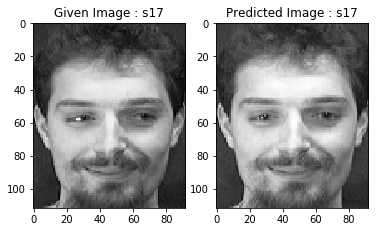

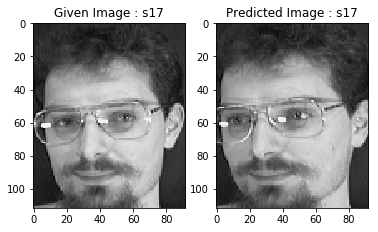

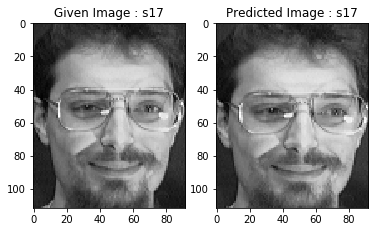

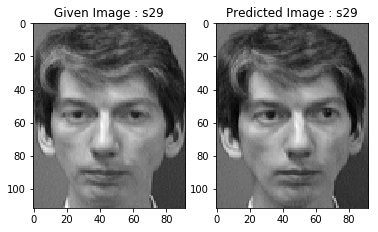

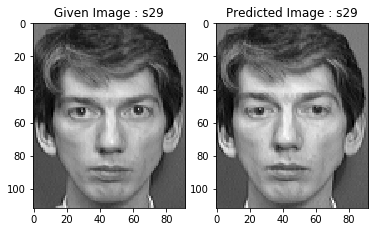

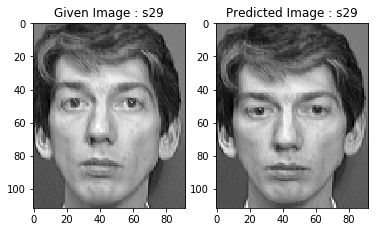

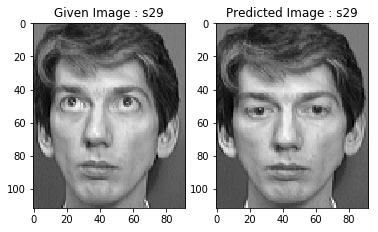

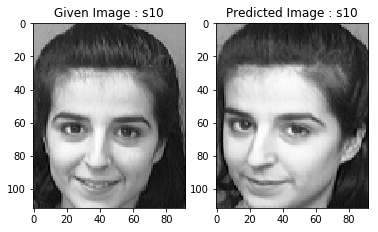

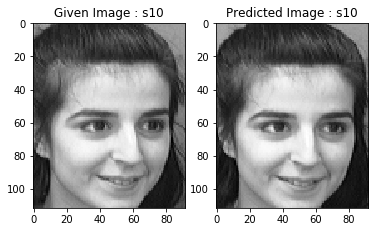

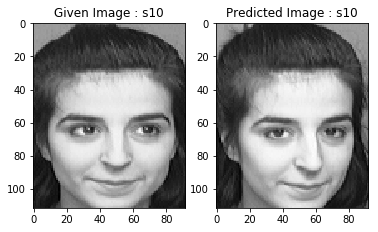

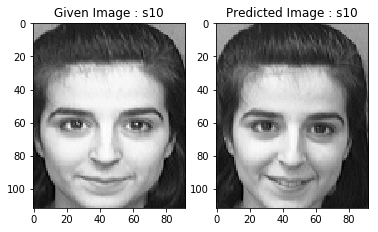

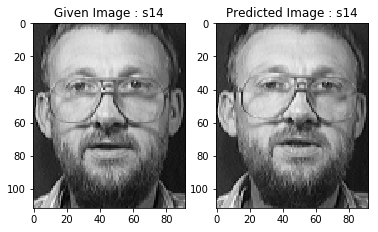

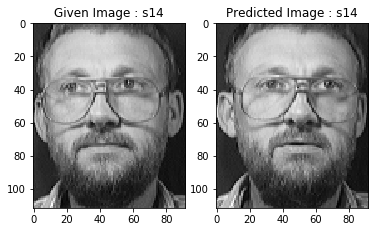

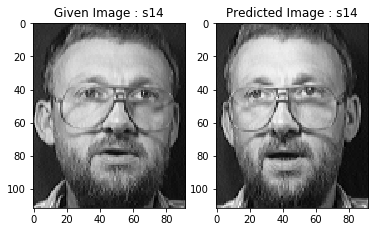

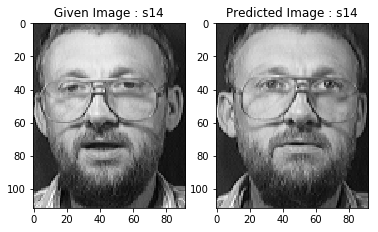

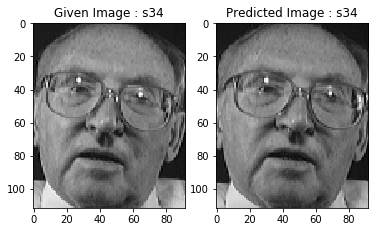

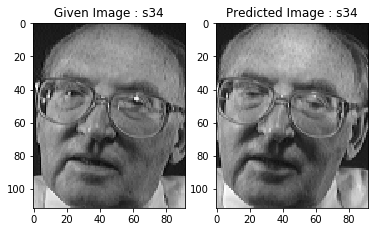

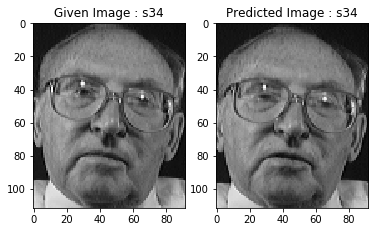

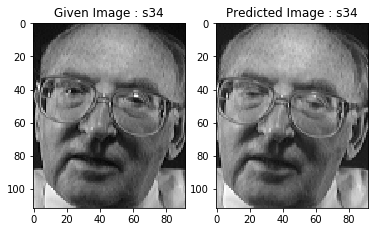

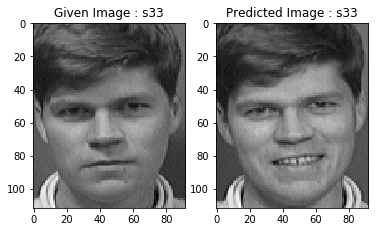

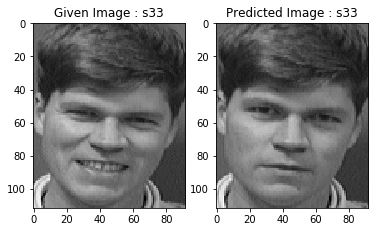

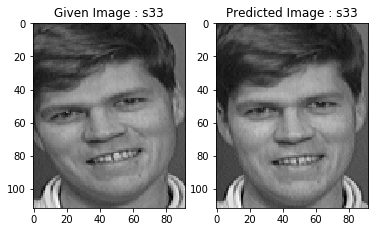

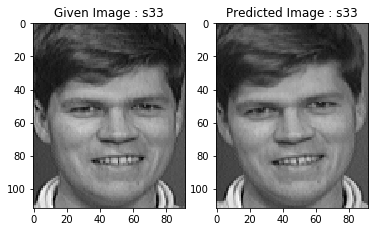

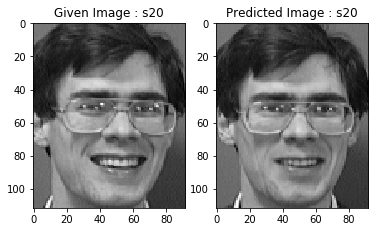

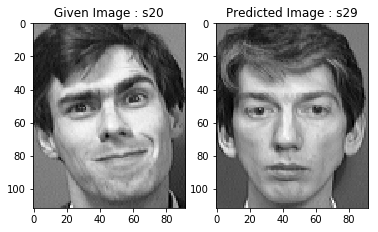

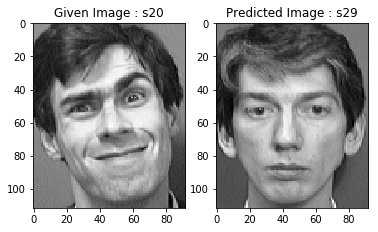

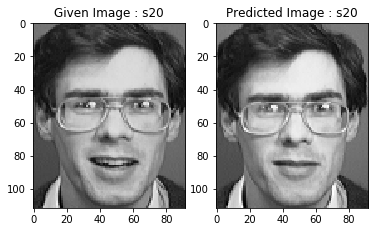

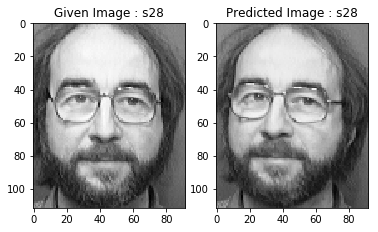

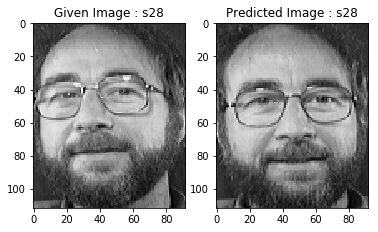

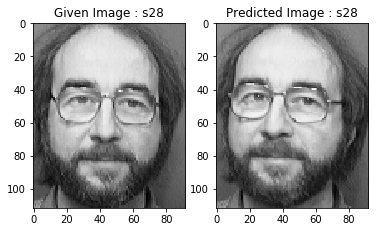

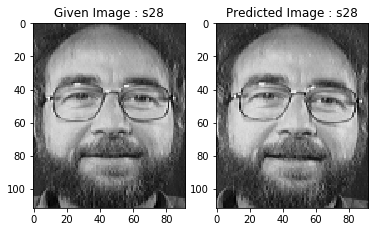

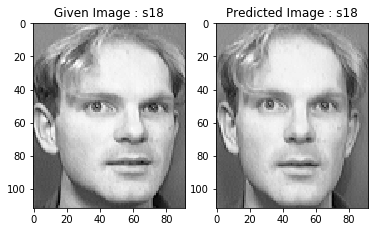

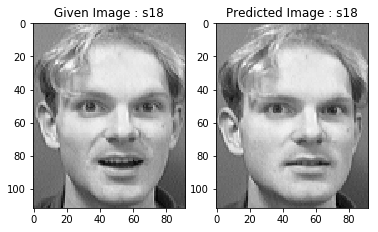

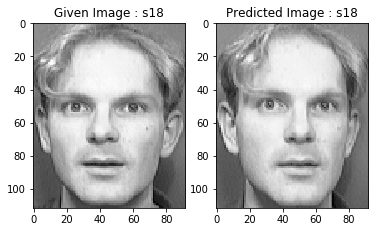

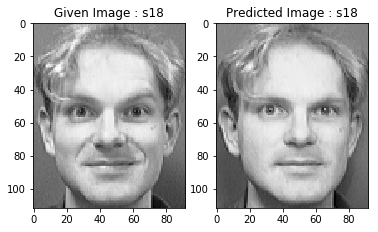

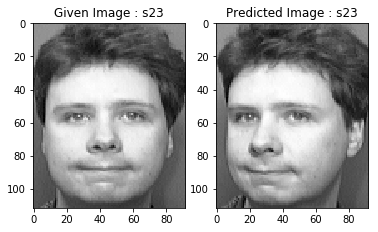

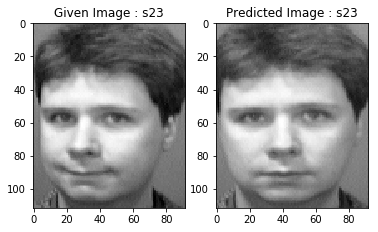

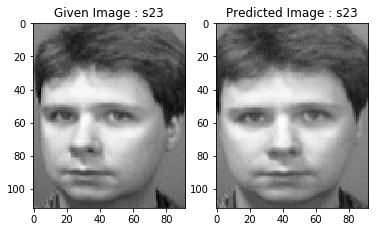

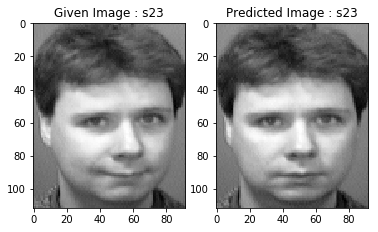

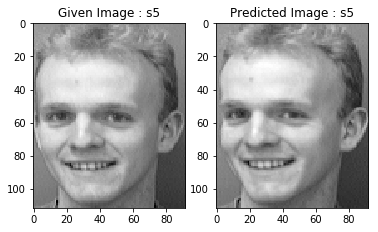

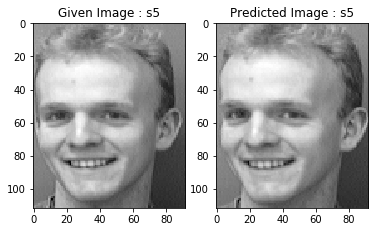

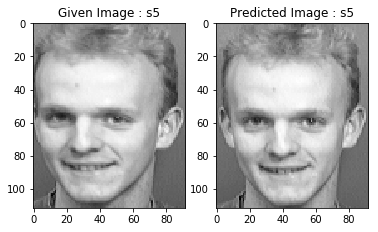

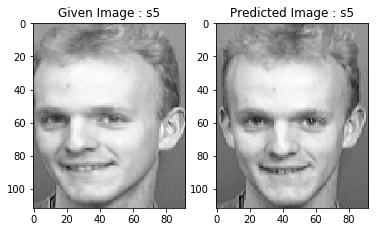

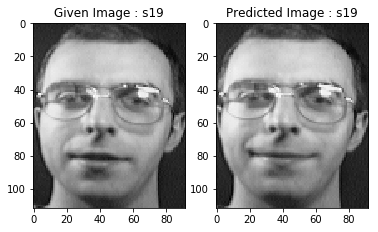

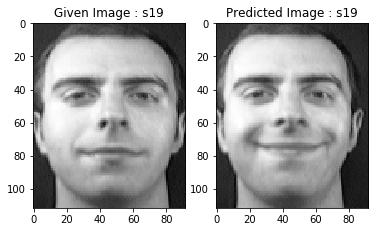

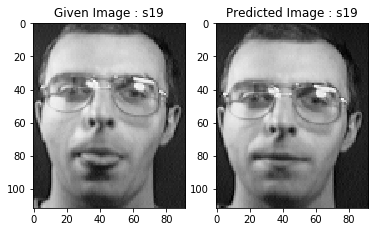

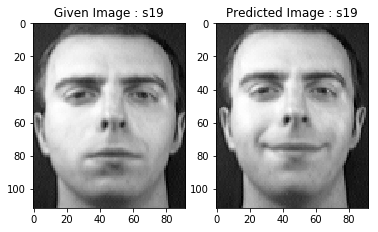

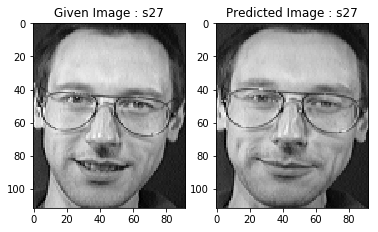

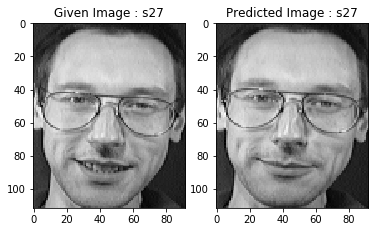

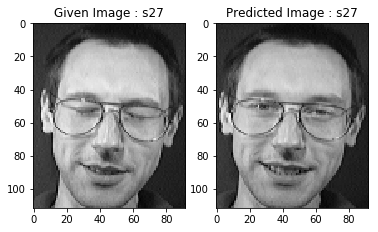

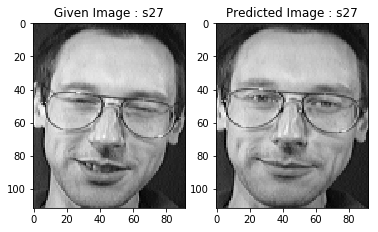

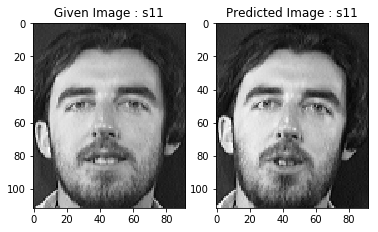

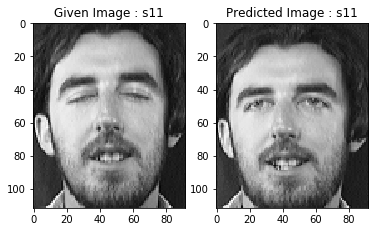

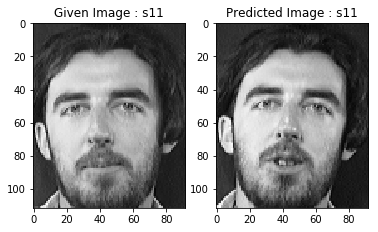

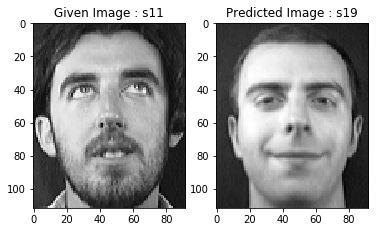

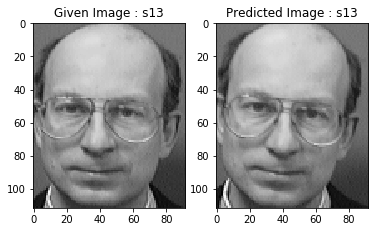

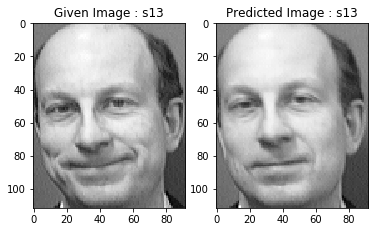

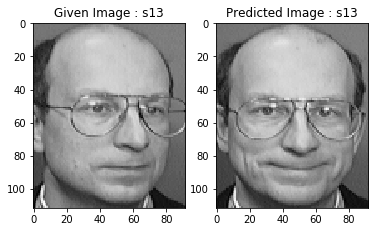

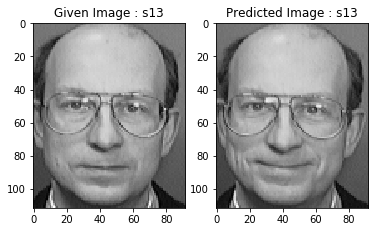

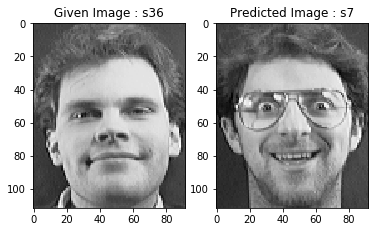

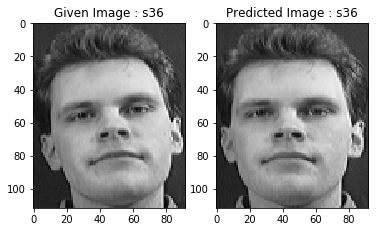

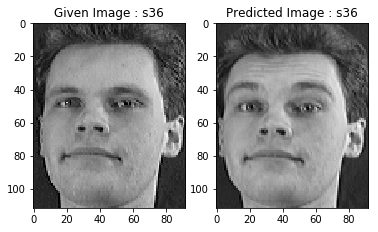

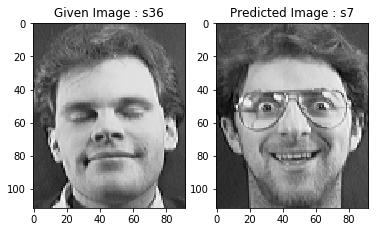

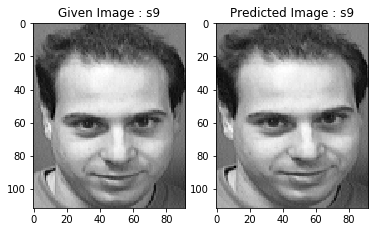

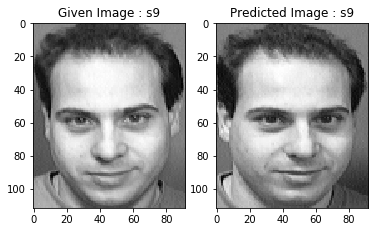

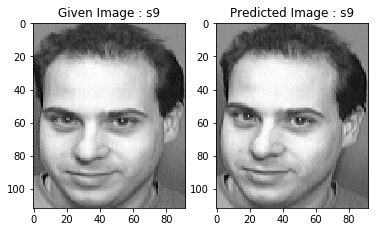

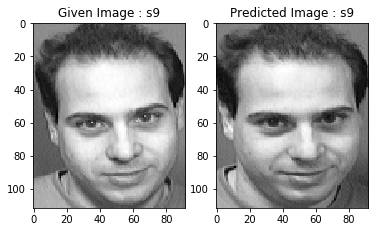

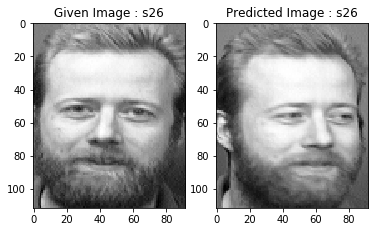

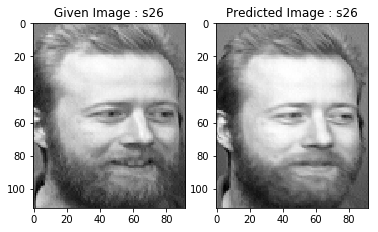

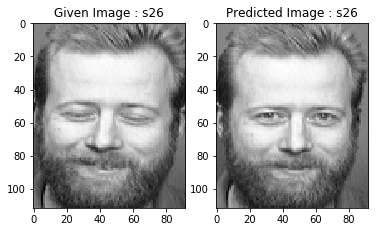

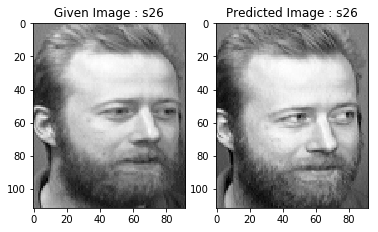

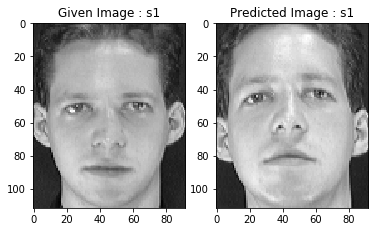

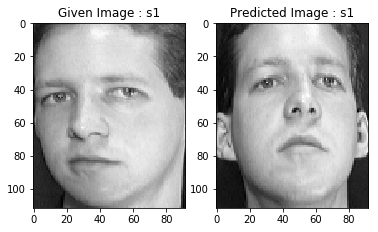

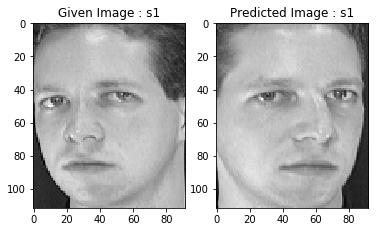

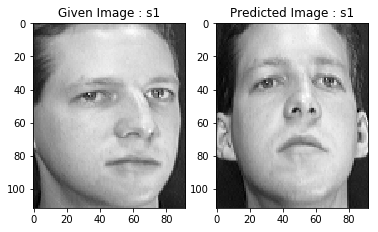

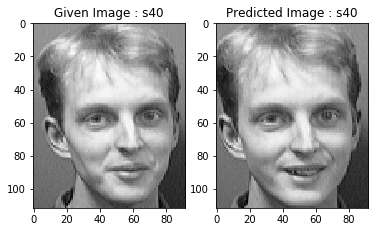

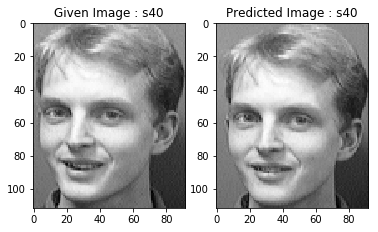

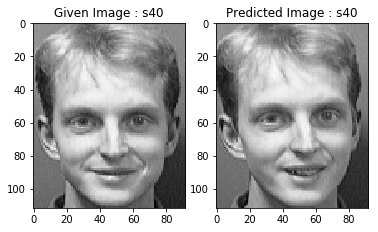

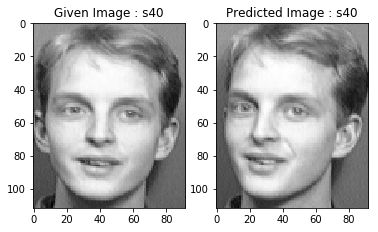

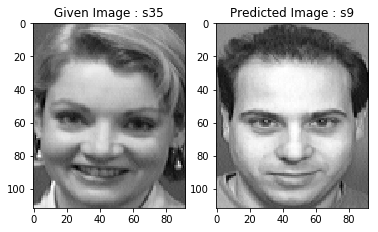

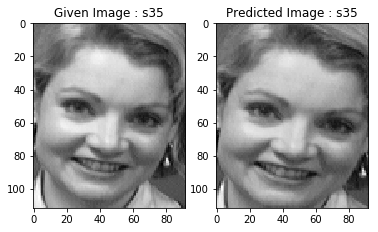

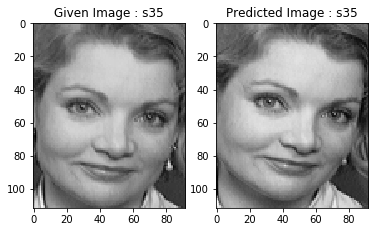

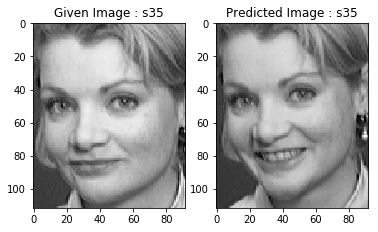

In [7]:
# Testing
ans = 0
for img,label in data_test:
    average_img = (img - mean)
    weight_img = average_img@eigen_faces.T
    fisher_img = weight_img@LDAKeigan_vectors
    min_distance = 1e19
    min_index = 0
    for i in range(len(Fisher_faces)):
        norm = np.linalg.norm(fisher_img - Fisher_faces[i])
        if  norm < min_distance:
            min_distance = norm
            min_index = i
    ans_label = ''
    for key, value in labels.items():
        if min_index in value:
            ans_label = key
    if label == ans_label:
        ans += 1

    fig,ax = plt.subplots(nrows = 1, ncols = 2)
    ax[0].set_title('Given Image : ' + label)
    ax[0].imshow(img.reshape(Original_dim), cmap='gray')
    
    ax[1].set_title('Predicted Image : ' + ans_label)
    ax[1].imshow(data_train[min_index].reshape(Original_dim), cmap='gray')
print('Accuracy', ans / len(data_test) * 100)